## Extract Features and Classify

In [1]:
# import necessary packages

# to extract features
import os
import librosa
import numpy as np
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt

# to scale features
from sklearn.preprocessing import MinMaxScaler

# for classification
import sklearn.model_selection as model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score

### Extract features

In [2]:
# function cal_stat takes a audio feature as argument and return its statistic measures:
# minimum, maximum, mean, standard deviation, skewness and kurtosis

def cal_stat(feature):
    min_val = np.min(feature,axis=1)
    max_val = np.max(feature,axis=1)
    mean_val = feature.mean(axis=1)
    std_val = feature.std(axis=1)
    skewness_val = skew(feature.T,bias = False)
    kurtosis_val = kurtosis(feature.T,fisher=False,bias=False)
    stat_val = np.hstack([min_val,max_val,mean_val,std_val,skewness_val,kurtosis_val])
    return stat_val

In [3]:
# create empty list to save values
labels = []
mfcc_info = []

In [4]:
# read audio one by one, extract label information and save it to labels list.
# extract MFCC and its first and second order derivatives. 
# Pass these features as an argulment to cal_stat() to obtain respective statistical measures.
dir_path = "./recordings/"
file_names =os.listdir(dir_path)
for f, file_name in enumerate(file_names):
    labels.append(file_name[0])
    file_path = os.path.join(dir_path,file_name)
    audio, sr = librosa.load(file_path, sr= None)
    
    mfccs = librosa.feature.mfcc(audio, sr=sr, n_mfcc=13, n_fft=1024)
    delta_mfccs = librosa.feature.delta(mfccs, width=3)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2, width=3)
    
    mfcc_stat = cal_stat(mfccs)
    d1mfcc_stat = cal_stat(delta_mfccs)
    d2mfcc_stat = cal_stat(delta2_mfccs)
    all_mfcc_stat = np.hstack([mfcc_stat,d1mfcc_stat,d2mfcc_stat])
    
    mfcc_info.append(all_mfcc_stat)

In [5]:
# convert labels and mfcc_info to numpy array 

audio_labels = np.asarray(labels)
mfccs = np.array(mfcc_info)

print("audio labels shape is: ", audio_labels.shape)
print("Total global features (MFCC and its derivatives) are: ", mfccs.shape)

audio labels shape is:  (3000,)
Total global features (MFCC and its derivatives) are:  (3000, 234)


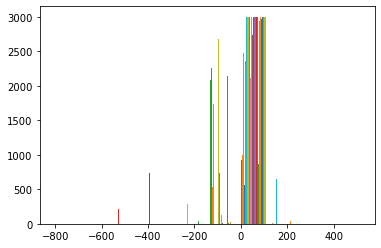

In [6]:
%matplotlib inline
plt.hist(mfccs);

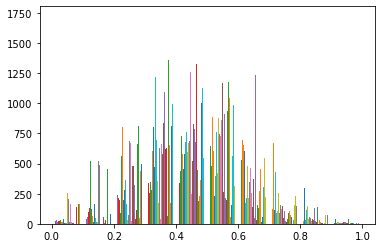

In [7]:
# scale mfccs using minmax 
mfccs_minmax = MinMaxScaler().fit_transform(mfccs)

%matplotlib inline
plt.hist(mfccs_minmax);

### classifying audios

In [8]:
# split features set into training and test dataset
# "stratify" option ensures that train and test dataset have all labels (targets) 
# in the same proportion

X_train, X_test, y_train, y_test = model_selection.train_test_split(mfccs_minmax,
                                        audio_labels,stratify= audio_labels,test_size=0.20)

In [9]:
# Random Forest Classifier

# instantiate model with proper parameters
rfc = RandomForestClassifier(class_weight="balanced",n_estimators=500,bootstrap=True)

# fit the model on training dataset
rfc.fit(X_train,y_train)

# check model on test dataset
pred_test = rfc.predict(X_test)

# check prediction accuracy 
pred_accuracy = accuracy_score(y_test,pred_test)
print("prediction accuracy is ", pred_accuracy)

# View confusion matrix and classification report
print(confusion_matrix(y_test,pred_test))

print(classification_report(y_test,pred_test))

prediction accuracy is  0.9833333333333333
[[60  0  0  0  0  0  0  0  0  0]
 [ 0 57  0  0  1  1  0  1  0  0]
 [ 1  0 59  0  0  0  0  0  0  0]
 [ 0  0  2 58  0  0  0  0  0  0]
 [ 0  0  0  0 59  1  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0  1]
 [ 0  0  0  0  0  0 59  0  1  0]
 [ 0  0  0  0  0  0  0 60  0  0]
 [ 0  0  0  0  0  0  0  0 60  0]
 [ 0  0  0  0  0  0  1  0  0 59]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      0.95      0.97        60
           2       0.97      0.98      0.98        60
           3       1.00      0.97      0.98        60
           4       0.98      0.98      0.98        60
           5       0.97      0.98      0.98        60
           6       0.98      0.98      0.98        60
           7       0.98      1.00      0.99        60
           8       0.98      1.00      0.99        60
           9       0.98      0.98      0.98        60

    accuracy                  

In [10]:
# confirm the accuracy with more robust method, 10-fold cross-validation

# define the model
rfc = RandomForestClassifier(class_weight="balanced", n_estimators=500, bootstrap=False)
rfc_scores = cross_val_score(rfc, mfccs_minmax, audio_labels, cv=10)
print("mean accuracy is %0.2f with a standard deviation of %0.2f" %(rfc_scores.mean(), rfc_scores.std()))
rfc_scores

mean accuracy is 0.97 with a standard deviation of 0.02


array([0.94      , 0.98333333, 0.98      , 0.99666667, 0.97333333,
       0.93      , 0.96      , 0.98      , 0.98666667, 0.96      ])